In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 常数均值

+ 一个平稳序列在时间上具有一个相对稳定的均值，这个值没有减少或者增加的趋势。围绕常数均值的小的变化，使我们更容易推测未来。在某些情况下，相对于平均值的变量比较小，使用它可以很好地预测未来。下图显示了变量与该常数平均值相对于时间变化的关系:

<Figure size 1296x288 with 0 Axes>

Text(0.5, 1.0, 'Series with Constant Mean')

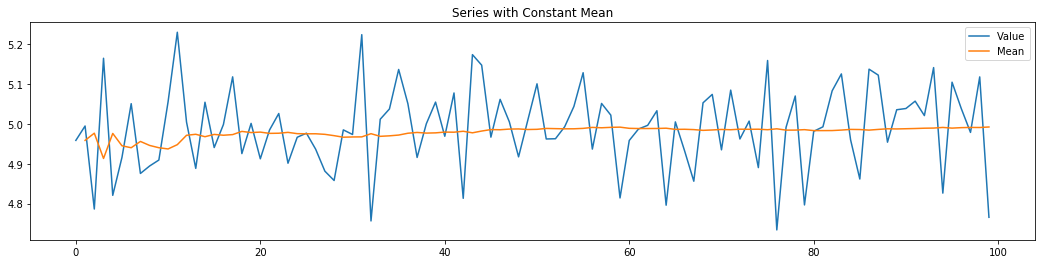

In [2]:
np.random.seed(2)
rand = [5] * 100 + np.random.randn(100) * 0.1


#Creating an average that expands from the first value and accumulate until each day
mean = [np.mean(rand[:x]) for x in range(len(rand))]
plt.figure(figsize=(18,4))
plt.plot(rand, label='Value')
plt.plot(mean, label='Mean')
plt.title('Series with Constant Mean')
plt.legend()
plt.show()

+ 在这种情况下，如果序列不是平稳的，对未来的预测将是无效的，因为平均值周围的变量会显著偏离，如下图所示:

<Figure size 1296x288 with 0 Axes>

Text(0.5, 1.0, 'Series with INconstant Mean')

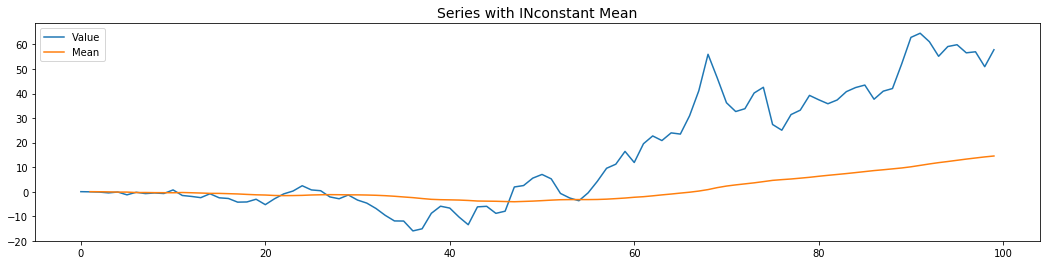

In [3]:
np.random.seed(1)
rand2 = np.cumsum([x for x in range(100) * np.random.randn(100) * 0.1])

#Creating an average that expands from the first value and accumulate until each day
mean2 = [np.mean(rand2[:x]) for x in range(len(rand2))]
plt.figure(figsize=(18,4))
plt.plot(rand2, label='Value')
plt.plot(mean2, label='Mean')
plt.title('Series with INconstant Mean', fontdict={'fontsize':14})
plt.legend()
plt.show()

+ 在上图中，我们可以明显看到上升的趋势，均值正在逐渐上升。在这种情况下，如果使用均值进行未来值的预测，误差将非常大，因为预测价格会总是低于实际价格。

# 常数方差

+ 当序列的方差为常数时，我们知道均值和标准差之间存在一种关系。当方差不为常数时（如下图所示），预测在某些时期可能会有较大的误差，而这些时期是不可预测的。可以预测到，随着时间的推移直到未来，方差会保持不稳定。

<Figure size 1296x288 with 0 Axes>

Text(0.5, 1.0, 'Series with INconstant variance')

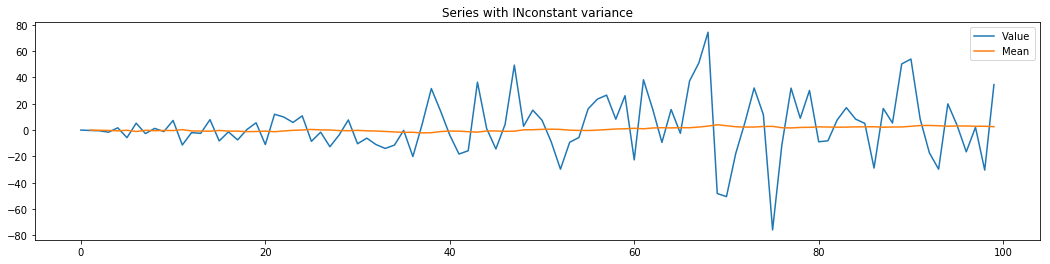

In [4]:
np.random.seed(1)
rand3 = [x for x in range(100) * np.random.randn(100) * 0.5]

#Creating an average that expands from the first value and accumulate until each day
mean3 = [np.mean(rand3[:x]) for x in range(len(rand3))]
plt.figure(figsize=(18,4))
plt.plot(rand3, label='Value')
plt.plot(mean3, label='Mean')
plt.title('Series with INconstant variance')
plt.legend()
plt.show()

+ 为了减小方差效应，可以采用对数变换。在本例中，也可以使用指数变换，如 Box-Cox 方法，或者使用膨胀率调整。 

# 自相关序列

+ 当两个变量在时间上的标准差有相似的变化时，你可以说这些变量是相关的。例如，体重会随着心脏疾病而增加，体重越大，心脏问题的发生率就越大。在这种情况下，相关性是正的，图形应该是这样的:

<Figure size 1296x288 with 0 Axes>

Text(0.5, 0, 'Weight')

Text(0, 0.5, 'Diseases')

Text(0.5, 1.0, 'Correlation between Weight and Diseases')

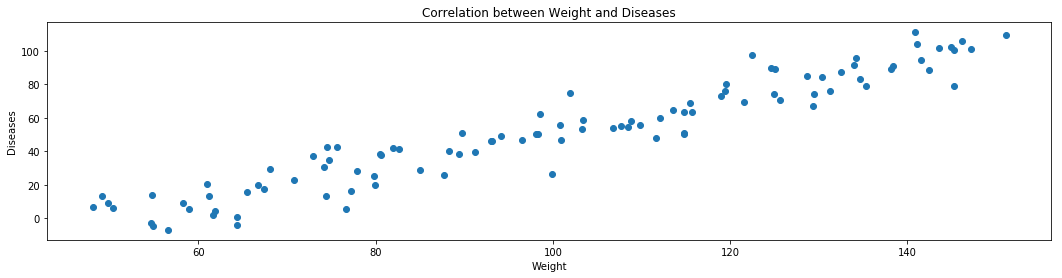

In [6]:
np.random.seed(1)
weight = [x for x in range(50,150)] + np.random.randn(100) * 3
diseases = [x for x in range(100)] + np.random.randn(100) * 10

plt.figure(figsize=(18,4))
plt.scatter(weight, diseases)
plt.xlabel('Weight')
plt.ylabel('Diseases')
plt.title('Correlation between Weight and Diseases')
plt.show()

+ 负相关的情况类似于这样：对工作安全措施的投入越多，工作相关的事故数量就越少。 

下面是几个相关级别的散点图的例子:
![](./时间序列.png)
当谈到自相关时，意思是某些先前时期与当前时期存在相关性，这种相关性是滞后的。例如，在以小时为单位的测量值序列中，今天 12:00 的温度与 24 小时前的 12:00 的温度非常相似。如果你比较 24 小时内的温度变化，就会存在自相关，在本例中，我们将与第 24 小时前的时间存在自相关关系。
自相关是使用单个变量创建预测的一种情况，因为如果没有相关性，就不能使用过去的值

# 具体例子

## 数据探索

从这里开始我将分析 Esalq 上的每周含水乙醇价格（这是巴西谈判含水乙醇的价格参考），数据可以在这里(https://www.cepea.esalq.usp.br/br/indicador/etanol.aspx)下载。
价格单位是巴西雷亚尔每立方米(BRL/m3)。
在开始任何分析之前，要将数据划分为训练集和测试集。

In [46]:
#Importing the data and transforming the price to the base of BRL/m3
file = './CEPEA_20190824222552.xls'
df = pd.read_excel(file)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values('Data')
df.columns = ['Date','Price']
df = df[df['Date'].dt.weekday == 4]
df.set_index('Date', inplace=True)
df.head()

,Price
Date,
2010-01-29,651.19
2010-02-05,629.63
2010-02-12,618.89
2010-02-19,631.02
2010-02-26,573.92


In [47]:
weeks = 156
train = df.iloc[:-weeks,0:1].copy()
test = df.iloc[-weeks:,0:1].copy()

<Figure size 1296x360 with 0 Axes>

Text(0.5, 1.0, 'Hydrous Ethanol Price - Esalq')

Text(0.5, 0, 'Dat')

Text(0, 0.5, 'Price')

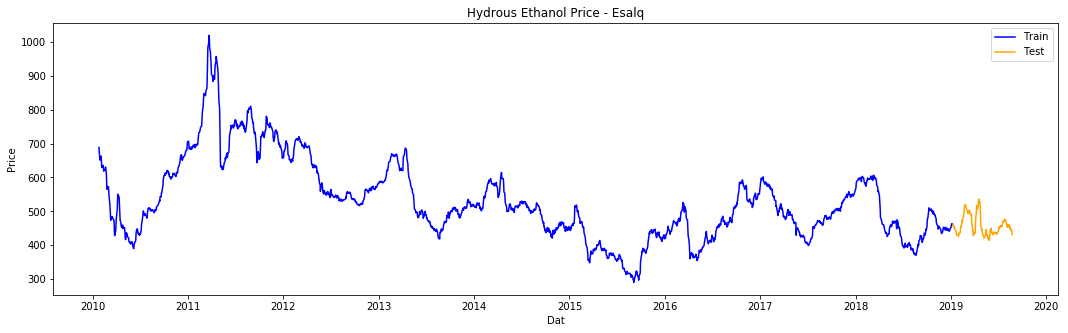

In [21]:
plt.figure(figsize=(18,5))
plt.title('Hydrous Ethanol Price - Esalq')
plt.plot(train['Price'], color='b')
plt.plot(test['Price'], color='orange')
plt.legend(['Train','Test'])
plt.xlabel('Dat')
plt.ylabel('Price')
plt.show()

+ 从现在开始，我们只使用训练集来做研究，测试集仅用于验证我们的预测。
+ 每一个时间序列可以分为三个部分：趋势、季节性和残差，残差是将前两部分从序列中去除后剩下的部分，使用这种分割方法之后：

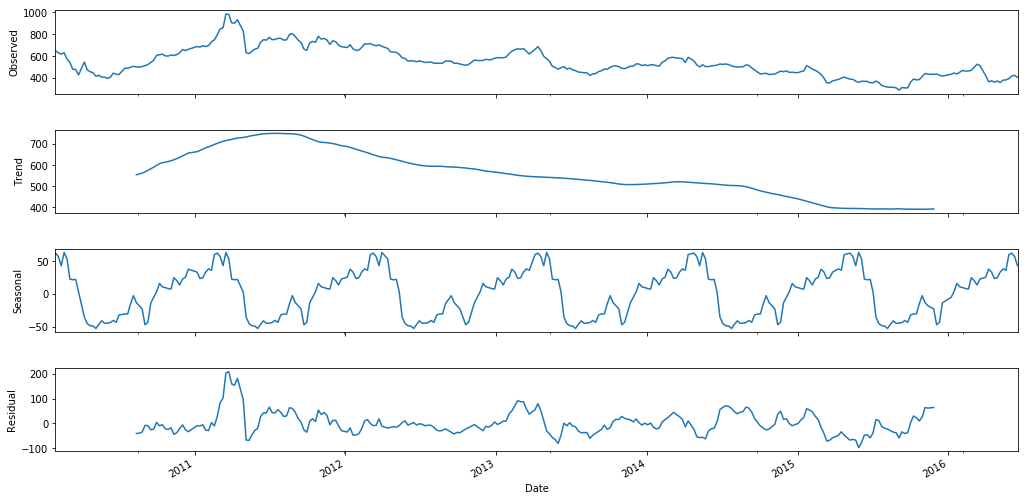

In [48]:
# weekly chart with cycles that repeat every 52 weeks (1 year)
season = seasonal_decompose(train, freq=52)
fig = season.plot();
fig.set_size_inches(16,8)

+ 第一行observed：原始数据；第二行trend：分解出来的趋势部分；第三行seasonal：周期部分；最后residual：残差部分。
+ seasonal_decompose的加法模型进行的分解，即 observed = trend + seasonal + residual，另还有乘法模型。

+ 显然，该序列具有下降趋势.在每一年的年底到年初之间达到峰值，在4月和9月之间达到最低值（此时在巴西中南部开始甘蔗的压榨）。
+ 我们仍然建议使用统计测试来确认序列是否是平稳的，这里将使用两个测试：Dickey-Fuller 测试和 KPSS 测试。
+ 首先，我们将使用 Dickey-Fuller 检验，我将使用 5% 的基础 P 值，也就是说，如果 P 值低于 5% 这意味着这个序列在统计上是平稳的。
+ 此外，还有模型的统计检验，可以将检验值与 1%、5%、10% 的临界值进行比较，如果统计检验低于选定的某个临界值，就认为序列是平稳的:

In [50]:
#Dickey Fuller Test
adfinput = adfuller(train['Price'])
adftest = pd.Series(adfinput[0:4], index=['Dickey Fuller Statistical Test', 'P-value',
                                          'Used Lags', 'Number of comments used'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Critical Value (%s)"%key] = value.round(4) 
adftest

print(f"在本例中，Dickey-Fuller 检验结果表明序列不是平稳的（ P 值 49%，临界值 5% 小于统计检验）。")

Dickey Fuller Statistical Test     -1.5739
P-value                             0.4967
Used Lags                           6.0000
Number of comments used           308.0000
Critical Value (1%)                -3.4518
Critical Value (5%)                -2.8710
Critical Value (10%)               -2.5718
dtype: float64

在本例中，Dickey-Fuller 检验结果表明序列不是平稳的（ P 值 49%，临界值 5% 小于统计检验）。


In [51]:
print(f"现在我们要用 KPSS 检验分析序列，与 Dickey-Fuller 检验不同，KPSS 检验已经假设序列是平稳的，只有当 P 值小于 5% 或统计检验小于某个临界值时，序列才不是平稳的：")

kpss_input = kpss(train['Price'])
kpss_test = pd.Series(kpss_input[0:3], index=['Statistical Test KPSS', 'P-Value', 'Used Lags'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Critical Value (%s)"%key] = value 
kpss_test

现在我们要用 KPSS 检验分析序列，与 Dickey-Fuller 检验不同，KPSS 检验已经假设序列是平稳的，只有当 P 值小于 5% 或统计检验小于某个临界值时，序列才不是平稳的：


Statistical Test KPSS     1.0912
P-Value                   0.0100
Used Lags                16.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64

## 将序列转换为平稳状态

### 差分
+ 差分法用来移除趋势信号，也可以用来减少方差，它只是 T 周期的值与前一个 T-1 周期值的差值。

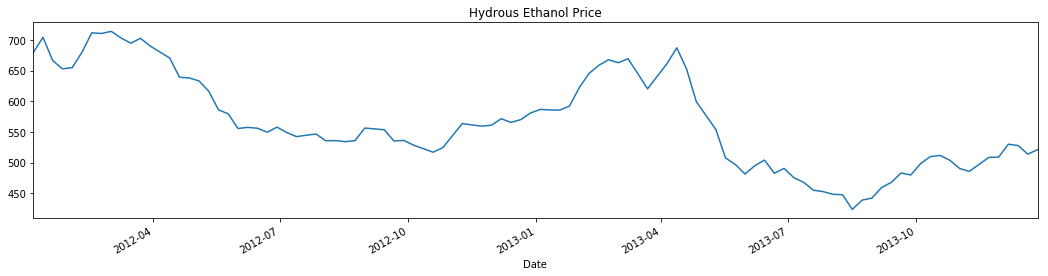

In [53]:
train.loc['2012':'2013','Price'].plot(figsize=(18,4), title='Hydrous Ethanol Price')
plt.show()

Text(0.5, 1.0, 'First difference of Ethanol prices')

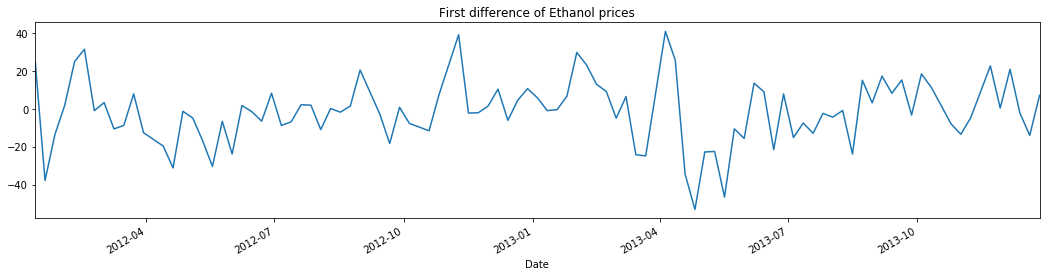

Showing the first 10 differentiations
Date
2010-02-05    -21.56
2010-02-12    -10.74
2010-02-19     12.13
2010-02-26    -57.10
2010-03-05    -31.65
2010-03-12    -62.70
2010-03-19     -0.95
2010-03-26    -50.36
2010-04-09    118.81
2010-04-16    -72.64
Name: Price, dtype: float64


In [58]:
train.loc['2012':'2013','Price'].diff().dropna().plot(figsize=(18,4))
plt.title('First difference of Ethanol prices')
plt.show()
print('Showing the first 10 differentiations')
print(train['Price'].diff().dropna().head(10))

In [59]:
# Differentiation of differentiation
print('Second differentiation')
train['Price'].diff().diff().dropna().head(10)

Second differentiation


Date
2010-02-12     10.82
2010-02-19     22.87
2010-02-26    -69.23
2010-03-05     25.45
2010-03-12    -31.05
2010-03-19     61.75
2010-03-26    -49.41
2010-04-09    169.17
2010-04-16   -191.45
2010-04-23     55.62
Name: Price, dtype: float64

+ 我们来做一下 Dickey-Fuller 测试，看看这个序列是否会在一阶微分后是平稳的：

In [60]:
#creating a function to plot the graph and show the test result:
def adfuller_test(serie, figsize=(18,4), plot=True, title=""):
    if plot:
        serie.plot(figsize=figsize, title=title)
        plt.show()
    #Dickey Fuller test on the first differentiation
    adf = adfuller(serie)
    output = pd.Series(adf[0:4], index=['Dickey Fuller Statistical Test', 'P-value',
                                        'Used Lags', 'Number of comments used'])
    output = round(output,4)
    
    for key, value in adf[4].items():
        output["Critical Value (%s)"%key] = value.round(4) 
    return output

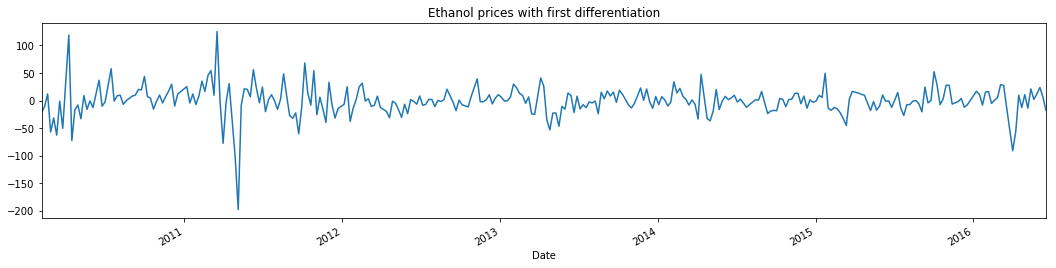

Dickey Fuller Statistical Test     -8.6967
P-value                             0.0000
Used Lags                           5.0000
Number of comments used           308.0000
Critical Value (1%)                -3.4518
Critical Value (5%)                -2.8710
Critical Value (10%)               -2.5718
dtype: float64

在这种情况下，我们确定该序列是平稳的，P 值为零，并且当我们比较统计检验的值时，它远远低于临界值。


In [62]:
adfuller_test(train['Price'].diff().dropna(), title='Ethanol prices with first differentiation')
print(f"在这种情况下，我们确定该序列是平稳的，P 值为零，并且当我们比较统计检验的值时，它远远低于临界值。")

## 膨胀率调整

+ 价格是相对于交易时间的，2002 年乙醇的价格是 680.00 BRL，如果现在产品的价格是这个价格，很多工厂肯定会倒闭，因为这个价格非常低。
+ 为了让序列平稳，我将基于当前值使用巴西 IPCA 索引（巴西的 CPI 指数）调整整个序列，从训练区间的结尾（2016年4月）到研究的开始，数据的来源是 IBGE 网站。

![](./时间序列1.png)
![](./时间序列2.png)
![](./时间序列3.png)
![](./时间序列4.png)

## 减小方差

### 对数变换

+ 对数变换通常用于将指数增长的序列转换为具有更趋于线性增长的序列，在本例中，我们将使用自然对数（Natural Logarithm，NL），其底数为 2.718 ，这种对数类型在经济模型中被广泛使用。
+ 转换成 NL 值的差值近似等于原始序列值的百分比变化，作为降低不同价格序列的方差的基础是很有效的，如下例:
+ 如果我们有一个产品在 2000 年价格上涨，从 50.00 BRL 到 52.50 BRL，几年后（2019年），价格已经是 100.00 BRL，已经上涨到 105.00 BRL，价格之间的绝对差分别是 2.50 BRL 和 5.00 BRL，但两者的百分比差为 5% 。
+ 当我们对这些价格中使用 NL 时，我们得到：NL (52.50) - NL(50.00) = 3.96 - 3.912 = 0.048 或 4.8%，同样地，在第二个价格序列中使用 LN 时，我们得到：NL (105) - NL(100) = 4.654-4.605 = 0.049 或 4.9% 。
+ 在这个例子中，我们可以通过把几乎所有的东西都放到相同的基上来减少差异值。

In [65]:
price1 = np.log(52.5) - np.log(50)
price2 = np.log(105) - np.log(100)
print(f'The percentage variation of the first example is {round(price1*100,1)} and the second is {round(price2*100,1)}')

The percentage variation of the first example is 4.9 and the second is 4.9


+ 下表为X的百分比变化值与NL (X)的变化值比较:
![](./时间序列5.png)

<Figure size 1296x288 with 0 Axes>

Text(0.5, 1.0, 'Original Series')

Text(0.5, 1.0, 'Series transformed by Natural Logarithm')

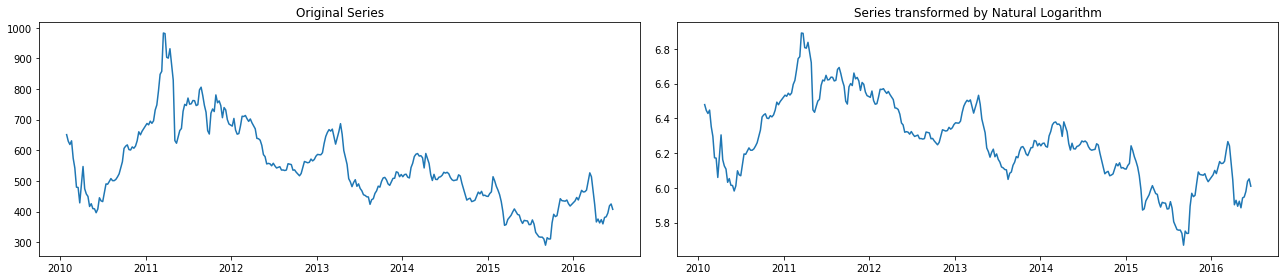

In [66]:
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.plot(train['Price'])
plt.title('Original Series')

#Transformed Series by NL
log = np.log(train['Price'])
plt.subplot(122)
plt.plot(log)
plt.title('Series transformed by Natural Logarithm')
plt.tight_layout()
plt.show()

### Box-Cox 变换（指数变换）

+ Box-Cox 转换也是一种转换序列的方法，lambda（λ）的值是用于转换序列的参数。
+ 简而言之，这个函数是几个指数变换函数的结合，我们需要找到转换序列的 lambda 的最佳值，使其分布更接近正态高斯分布。使用此转换的一个条件是序列只有正值，公式为：
$X={\begin{cases}{\dfrac {X^{\lambda }-1}{\lambda }},&{\text{if }}\lambda \neq 0\\[12pt]\operatorname \ln {(X)}&{\text{if }}\lambda =0\end{cases}}$
+ 接下来我将绘制原始序列及其分布图，然后用 lambda 最佳值绘制新的转换序列及其分布图，为了找到 lambda 的值，我们将使用库 Scipy 的 boxcox 函数生成转换的序列和理想 lambda 值：

<Figure size 1296x360 with 0 Axes>

Text(0.5, 1.0, 'Original Series')

(array([15., 40., 64., 82., 37., 38., 26.,  6.,  4.,  3.]),
 array([290.   , 359.323, 428.646, 497.969, 567.292, 636.615, 705.938,
        775.261, 844.584, 913.907, 983.23 ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Distribution of the Original Series')

The Lambda value was -0.024640863513254962


Text(0.5, 1.0, 'Transformed Series')

(array([ 9., 11., 27., 54., 69., 50., 41., 40.,  9.,  5.]),
 array([5.29162773, 5.3962225 , 5.50081727, 5.60541204, 5.71000681,
        5.81460158, 5.91919635, 6.02379112, 6.12838589, 6.23298066,
        6.33757543]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Distribution of the Transformed Series')

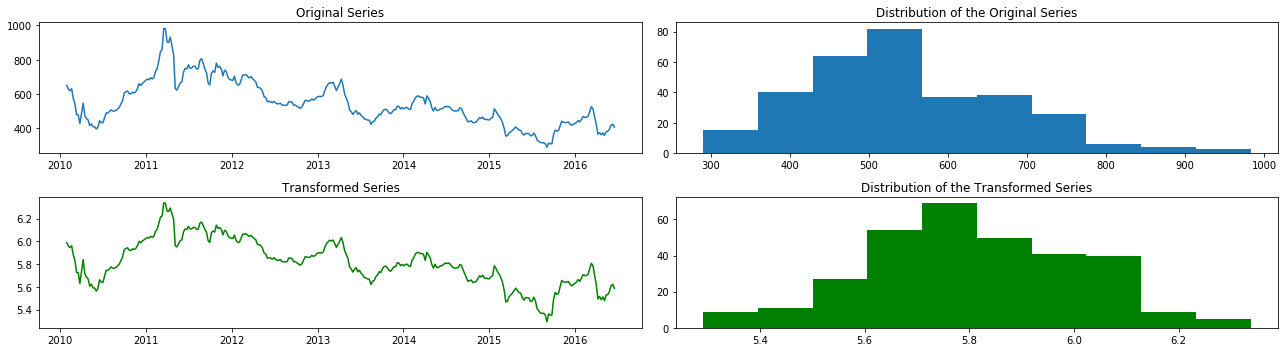

In [67]:
plt.figure(figsize=(18,5))
plt.subplot(221)
plt.plot(train['Price'])
plt.title('Original Series')

plt.subplot(222)
plt.hist(train['Price'])
plt.title('Distribution of the Original Series')

#Transforming the series
from scipy.stats import boxcox
train['BOXCOX'], lmbda_ = boxcox(train['Price'])
print(f'The Lambda value was {lmbda_}')

plt.subplot(223)
plt.plot(train['BOXCOX'], color='green')
plt.title('Transformed Series')

plt.subplot(224)
plt.hist(train['BOXCOX'], color='green')
plt.title('Distribution of the Transformed Series')
plt.tight_layout()

+ Below is an interactive chart where you can change the lambda value and check the change in the chart

In [68]:
import ipywidgets as widgets
from ipywidgets import interactive

def f(lmbda):
    plt.figure(figsize=(18,4))
    if lmbda == 0:
        train['Box Cox'] = np.log(train['Price'])
    else:
        train['Box Cox'] = (train['Price']**lmbda - 1)/lmbda
    plt.plot(train['Box Cox'])
    plt.title(f'Box Cox Transformation with Lambda {lmbda}', fontdict={'fontsize':16})
    plt.show()

interactive_plot = interactive(f, lmbda=(-5,5,0.5))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='lmbda', max=5.0, min=-5.0, step=0.5), Output()), _do…

+ 此工具通常用于提高模型的性能，因为它使模型更趋于正态分布，记住在完成模型的预测后，必须根据以下公式反转转换到原始的基数：
$X={\begin{cases}{(X \lambda+1)^{1/ \lambda }},&{\text{if }}\lambda \neq 0\\[12pt]\operatorname \exp {(X)}&{\text{if }}\lambda =0\end{cases}}$

## 寻找相关时滞

+ 为了便于预测，具有单一变量的序列必须具有自相关性，即，当前时段必须是能够基于较早的时段（滞后）而解释的。
+ 由于这个序列每周为一周期，1 年大约 52 周，我将使用 60 的滞后期的自相关函数来验证当前周期与这些滞后的相关性。

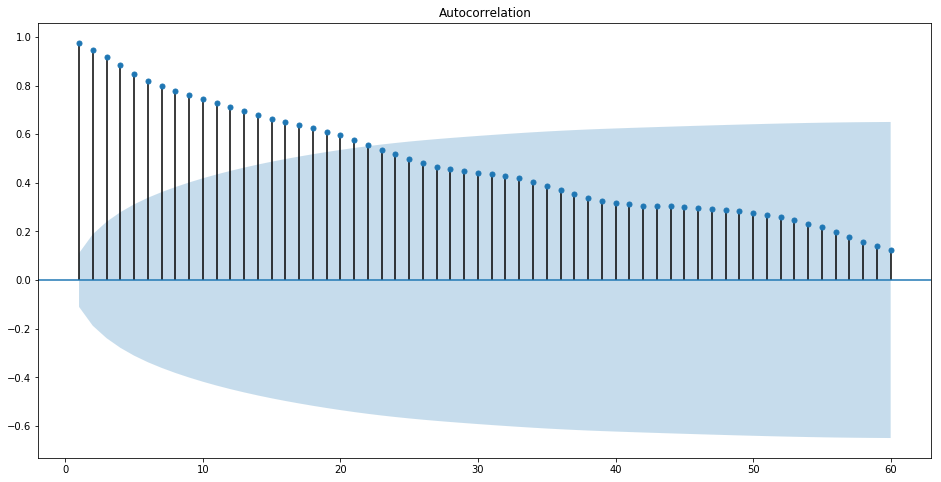

In [77]:
ax = plot_acf(train['Price'], lags=60, zero=False)
ax.set_size_inches(16,8)

+ 通过对上述自相关图的分析，似乎所有的滞后都可以用来为未来事件创建预测，因为它们的正相关接近 1 ，而且都在置信区间之外，但这一特征属于非平稳序列。

+ 另一个非常重要的函数是偏自相关函数，其中消除了先前的滞后对当前区间的影响，只保留了当前区间滞后的影响来分析，例如：第四个滞后的偏自相关将消除第一、第二和第三个滞后的影响。

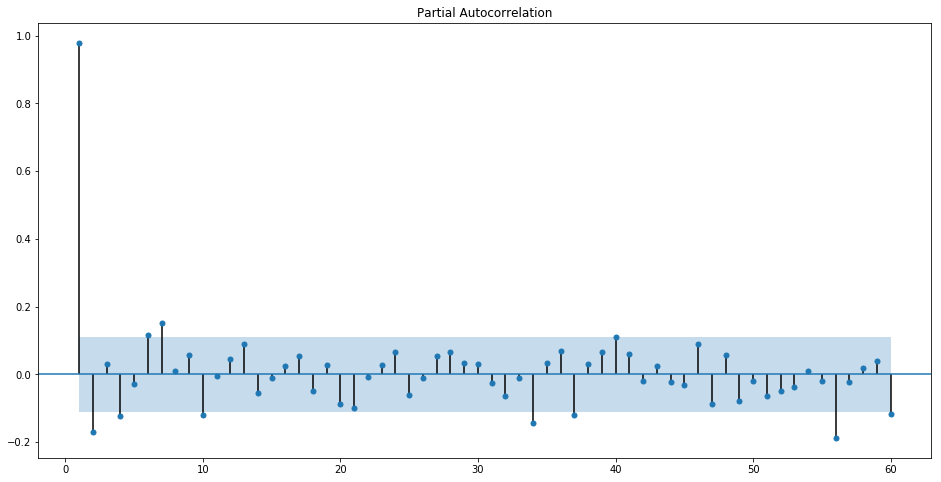

In [78]:
ax = plot_pacf(train['Price'], lags=60, zero=False)
ax.set_size_inches(16,8)

+ 可以看到，几乎没有滞后对当前周期有影响，但是正如前面所演示的，没有微分的序列不是平稳的，我们现在用一阶微分的序列绘制这两个函数来展示原理：

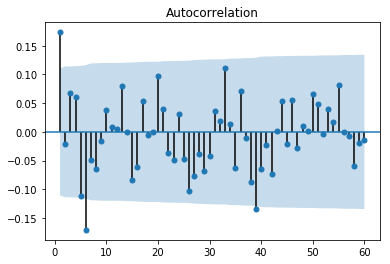

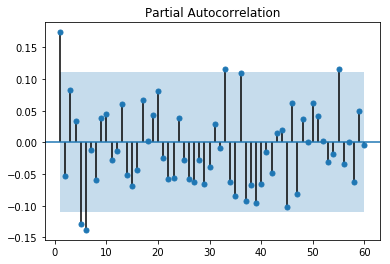

In [79]:
plot_acf(train['Price'].diff().dropna(), lags=60, zero=False);
plot_pacf(train['Price'].diff().dropna(), lags=60, zero=False);

+ 自相关曲线变化显著，表明该序列仅在第一个滞后期具有显著相关，在第 26 个滞后(半年)左右具有负相关的季节效应。
+ 为了做出预测，我们必须注意一个找到相关的滞后现象的非常重要的细节，重要的是这种关联背后的原因，因为如果没有逻辑上的原因，就有可能是偶然的，当包含更多的数据时，这种关联就会消失。
+ 另一个重点是自相关和偏自相关图对异常值非常敏感，因此分析时间序列本身并与两个自相关图进行对比非常重要。
+ 在这个例子中，第一个滞后与当前周期具有高度相关性，因为前一周的价格历史上没有显著变化，在相同的情况下，第 26 个滞后呈现负相关，表明与当前时期相反的趋势，可能原因是一年内不同时期供需不同。

## 模型评价指标

In [81]:
#Libraries to create the function:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_error(orig, pred, name_col='', index_name=''):
    
    bias = np.mean(orig - pred)
    mse = mean_squared_error(orig, pred)
    rmse = sqrt(mean_squared_error(orig, pred))
    mae = mean_absolute_error(orig, pred)
    mape = np.mean(np.abs((orig - pred) / orig)) * 100
    
    error_group = [bias, mse, rmse, mae, mape]
    serie = pd.DataFrame(error_group, index=['BIAS','MSE','RMSE','MAE', 'MAPE'], columns=[name_col])
    serie.index.name = index_name
    
    return serie

def plot_error(data, figsize=(18,8)):

    # Creating the column error
    data['Error'] = data.iloc[:,0] -data.iloc[:,1]

    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))

    #Plotting actual and predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Real Value vs Prediction')

    # Error vs Predicted value
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residual')
    ax2.set_title('Residual vs Predicted Values')

    ## Residual QQ Plot
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)

    # Autocorrelation Plot of residual
    plot_acf(data.iloc[:,2], lags=60, zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

SIMPLE MODEL IN THE TRAINING DATA


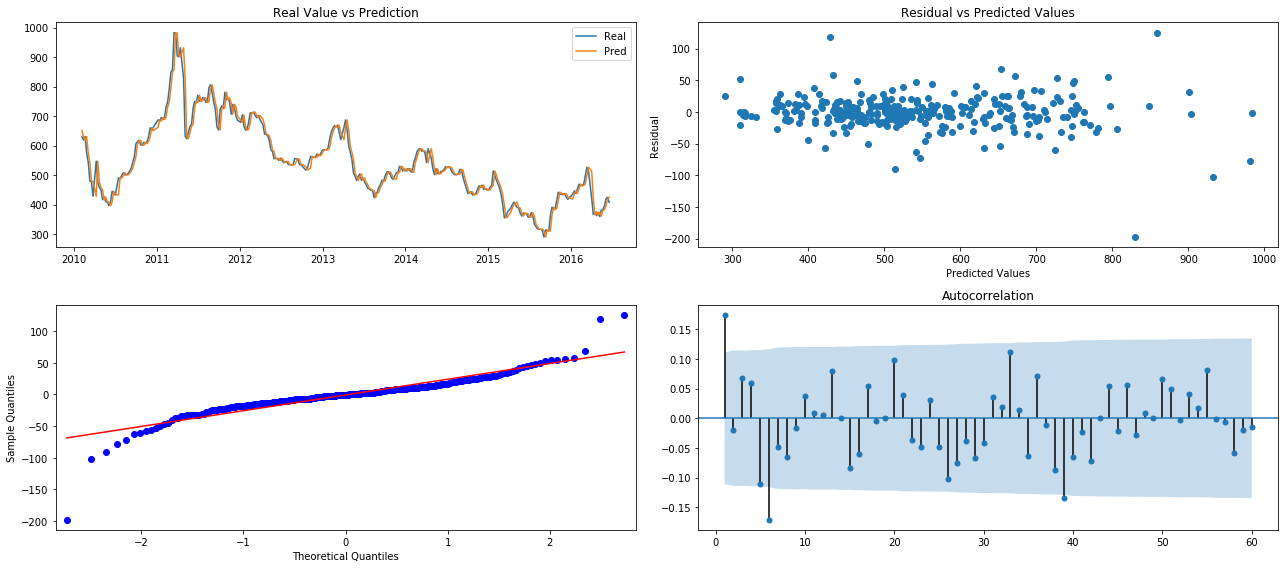

,Simple
Training Base,
BIAS,-0.776975
MSE,710.170676
RMSE,26.649028
MAE,16.880605
MAPE,3.106204


In [87]:
#Creating the training variable to compare with the error later
simple_train = train[['Price']]
simple_train.columns = ['Real']
simple_train['Pred'] = simple_train['Real'].shift()
simple_train.dropna(inplace=True)

error_train = check_error(simple_train['Real'], 
                         simple_train['Pred'], 
                         name_col='Simple', 
                         index_name='Training Base')

print('SIMPLE MODEL IN THE TRAINING DATA')
plot_error(simple_train)
error_train

SIMPLE MODEL IN THE TEST DATA


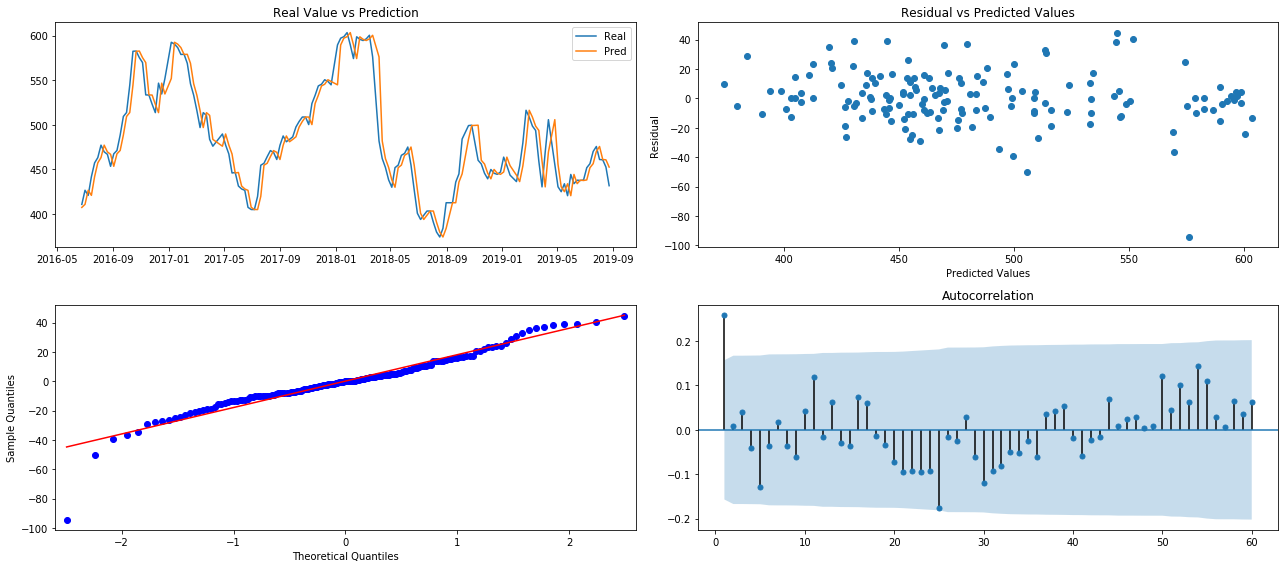

,Simple
Testing Base,
BIAS,0.156410
MSE,329.611758
RMSE,18.155213
MAE,13.003590
MAPE,2.711909


In [88]:
simple_test = test[['Price']]
simple_test.columns = ['Real']

#adding the first value of the Forecast with the last Actual data of the test
hist = [simple_train.iloc[i,0] for i in range(len(simple_train))]

pred = []
for t in range(len(simple_test)):
    yhat = hist[-1]
    obs = simple_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)

simple_test['Pred'] = pred

#creating the basis of error in the test
error_test = check_error(simple_test['Real'], 
                        simple_test['Pred'], 
                        name_col='Simple',
                       index_name='Testing Base')

print('SIMPLE MODEL IN THE TEST DATA')
plot_error(simple_test)
error_test

### 简单平均

,Simple,Simple Mean
Training Base,,
BIAS,-0.7770,-48.3807
MSE,710.1707,16627.9455
RMSE,26.6490,128.9494
MAE,16.8806,109.5411
MAPE,3.1062,22.4626


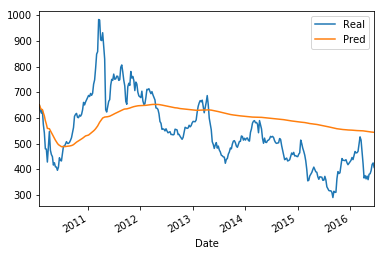

In [91]:
sm_train = train[['Price']]
sm_train.columns = ['Real']
sm_train['Pred'] = sm_train['Real'].expanding().mean()
sm_train.plot()
#Verifying the Simple Mean Template Error
error_train['Simple Mean'] = check_error(sm_train['Real'], sm_train['Pred'])
error_train.round(4)

SIMPLE MEAN MODEL IN THE TEST DATA


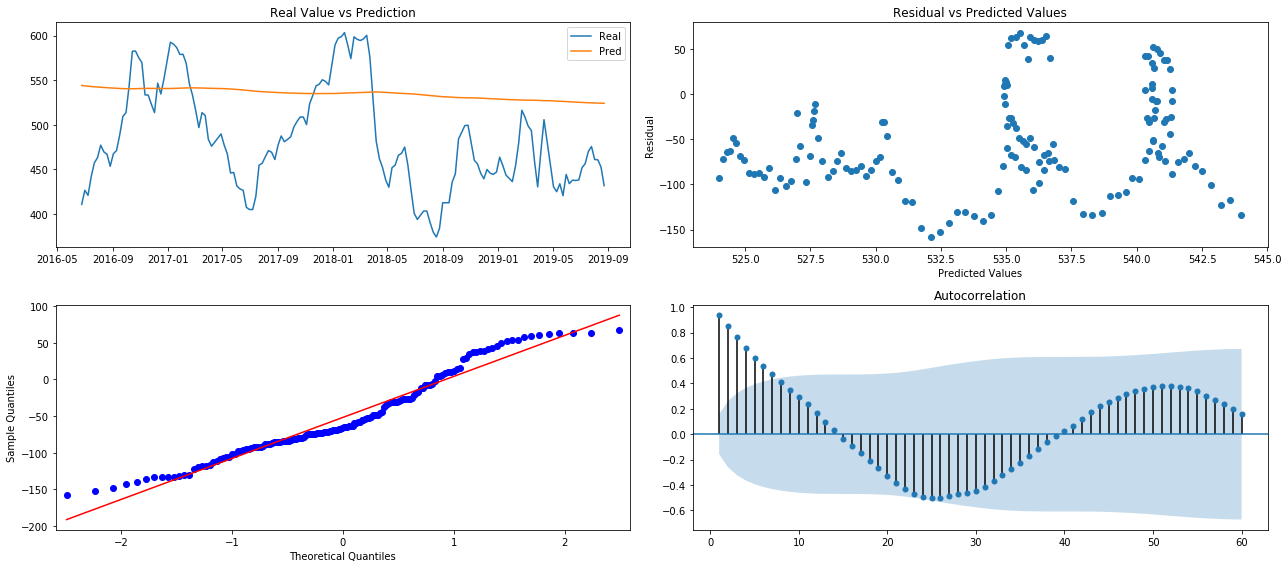

,Simple,Simple Mean
Testing Base,,
BIAS,0.156410,-51.815654
MSE,329.611758,5767.457767
RMSE,18.155213,75.943780
MAE,13.003590,66.759984
MAPE,2.711909,14.735171


In [94]:
sm_test = test[['Price']]
sm_test.columns = ['Real']

# Continuing to use the average for the test series
hist = [sm_train.iloc[i,0] for i in range(len(sm_train))]
pred = []
for t in range(len(sm_test)):
    yhat = np.mean(hist)
    obs = sm_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)

sm_test['Pred'] = pred

#ploting the test chart
print('SIMPLE MEAN MODEL IN THE TEST DATA')
plot_error(sm_test)

#Adding the simple mean error in the test:
error_test['Simple Mean'] = check_error(sm_test['Real'], sm_test['Pred'])
error_test

+ 简单均值模型无法捕获序列的相关信息，如真实值和预测值图中所示，也可以在相关性和残差和预测图中看到。

### 简单滑动平均
+ 滑动平均是针对给定周期（例如 5 天）计算的平均值，它是滑动的并始终使用此特定时段进行计算，在这种情况下，我们将始终使用过去 5 天的平均值来预测下一天的值。

In [96]:
sma_train = train[['Price']]
sma_train.columns = ['Real']
sma_train['Pred'] = sma_train.rolling(5).mean()
sma_train.dropna(inplace=True)

# Checking the error of the moving averages on the training model
error_train['5D Moving Avg'] = check_error(sma_train['Real'], sma_train['Pred'])
error_train.round(4)

,Simple,Simple Mean,5D Moving Avg
Training Base,,,
BIAS,-0.7770,-48.3807,-1.3865
MSE,710.1707,16627.9455,1060.4105
RMSE,26.6490,128.9494,32.5639
MAE,16.8806,109.5411,22.0174
MAPE,3.1062,22.4626,4.1015


+ 误差低于简单平均，但仍高于简单模型，以下是测试模型:

5-DAY MOVING AVERAGE MODEL ON THE TEST DATA


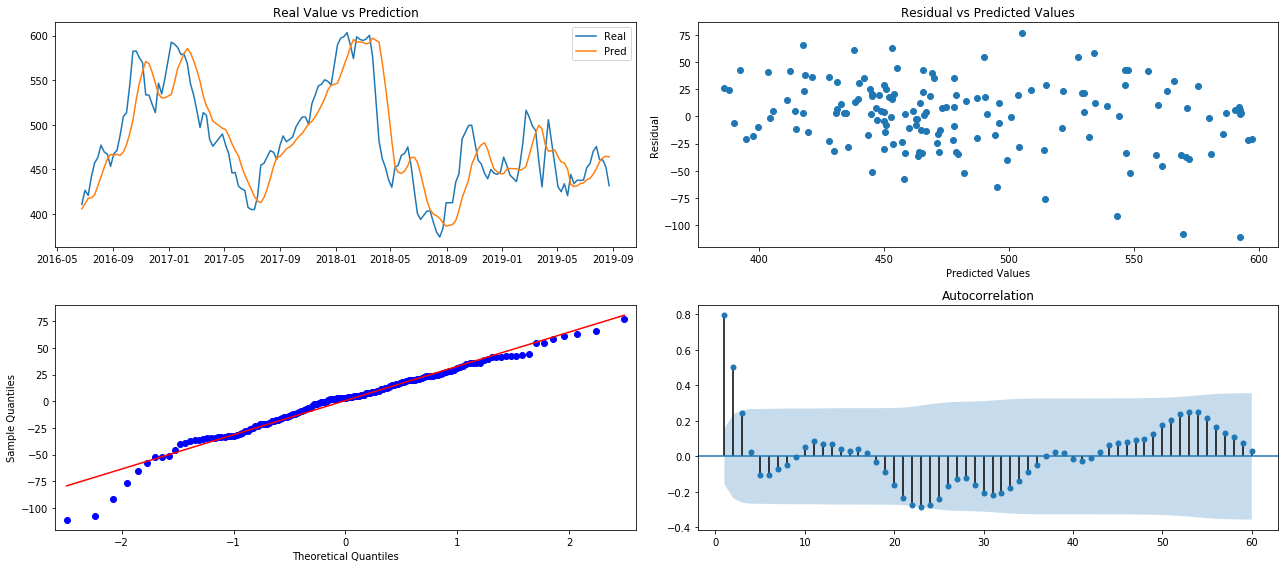

,Simple,Simple Mean,5D Moving Avg
Testing Base,,,
BIAS,0.156410,-51.815654,0.748833
MSE,329.611758,5767.457767,1004.483192
RMSE,18.155213,75.943780,31.693583
MAE,13.003590,66.759984,24.473218
MAPE,2.711909,14.735171,5.110594


In [97]:
sma_test = test[['Price']]
sma_test.columns = ['Real']

# Continuing to use the 5-day moving average step by step:
hist = [sma_train.iloc[i,0] for i in range(len(sma_train))]
pred = []
for t in range(len(sma_test)):
    yhat = np.mean(hist[-5:])
    obs = sma_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)
    
sma_test['Pred'] = pred

#plotting the test chart
print('5-DAY MOVING AVERAGE MODEL ON THE TEST DATA')
plot_error(sma_test)

# Checking the error of the moving average on test model
error_test['5D Moving Avg'] = check_error(sma_test['Real'], sma_test['Pred'])
error_test

### 指数滑动平均

+ 上述简单滑动平均模型具有同等地处理最后 X 个观测值并完全忽略所有先前观测值的特性。直观地说，过去的数据应该逐渐打折，例如，理论上最近的观测结果应该比第二近的更重要，而第二近的观测应该比第三近的数据更重要，等等， 指数滑动平均（Exponential Moving Average，EMM）模型就是这样做的。
+ 由于 α（alpha）是一个常数，其值介于 0 和 1 之间，因此我们将使用以下公式计算预测值：
$ Ypred_{t} = Ypred _{t-1} + \alpha(Ypred _{t-1} - Ypred_{t-1})$
+ 如果预测的第一个值是相应的当前值，其他值将更新为实际值与前一个时段的预测之差的 α 倍。当α为零时，我们根据第一个预测值得到一个常数，当 α 为 1 时，我们有一个简单方法的模型，因为结果是前一个实际周期的值。

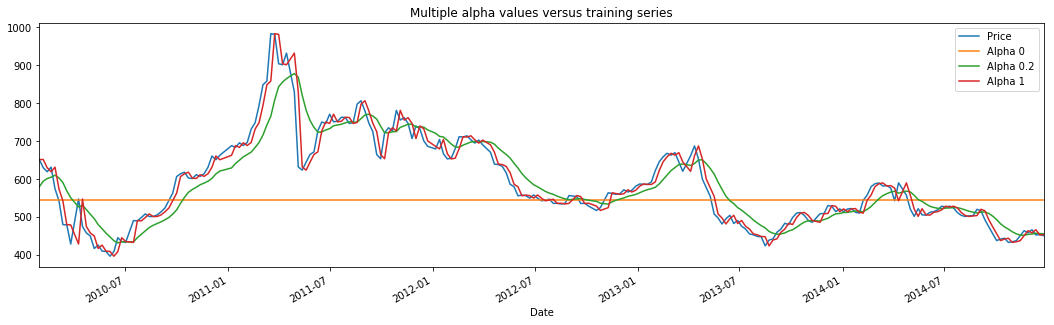

In [103]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
emm = train[['Price']]
alpha_ = [0, 0.2, 1]
for key, value in enumerate(alpha_):
    model = ExponentialSmoothing(emm['Price']).fit(smoothing_level= value)
    emm[f'Alpha {value}'] = model.predict(start=0, end=len(emm)-1)

#plotting part of the graph to improve visualization
emm[:'2014'].plot(figsize=(18,5), title='Multiple alpha values versus training series')
plt.show()

+ EMM 预测中的平均数据周期为 1 /α。例如，当 α= 0.5 时，滞后相当于 2 个周期; 当 α= 0.2 时，滞后是 5 个周期; 当 α= 0.1 时，滞后是 10 个周期，依此类推。
+ 在这个模型中，我们将任意选用 α 值为 0.5 ，而你可以通过网格搜索算法查找在训练集和验证集中都中减少了错误的 α，数据大概应是这样：

In [104]:
emm_train = train[['Price']]
emm_train.columns = ['Real']

# Creating the model:
alpha = 0.5
model = ExponentialSmoothing(emm_train['Real']).fit(smoothing_level= alpha)
emm_train['Pred'] = model.predict(start=0, end=len(emm_train)-1)

# Checking the error of the exponential moving averages training model
error_train['Exp. Moving Avg'] = check_error(emm_train['Real'], emm_train['Pred'])
error_train

,Simple,Simple Mean,5D Moving Avg,Exp. Moving Avg
Training Base,,,,
BIAS,-0.776975,-48.380689,-1.386457,-1.417022
MSE,710.170676,16627.945540,1060.410492,1107.936294
RMSE,26.649028,128.949391,32.563945,33.285677
MAE,16.880605,109.541113,22.017363,22.252195
MAPE,3.106204,22.462558,4.101531,4.121165


+ 这个模型的误差与滑动平均的误差相似，但是我们需要在测试集对模型进行验证：

EXPONENTIAL MOVING AVERAGE WITH 0.50 ALPHA ON THE TEST DATA


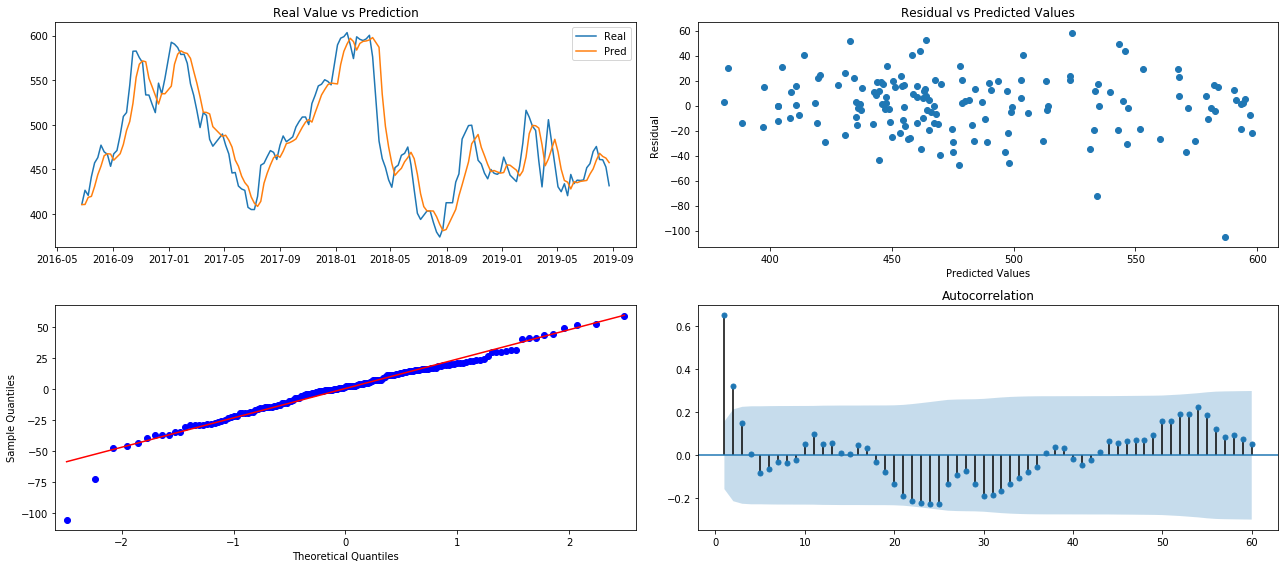

,Simple,Simple Mean,5D Moving Avg,Exp. Moving Avg
Testing Base,,,,
BIAS,0.156410,-51.815654,0.748833,0.437266
MSE,329.611758,5767.457767,1004.483192,550.945093
RMSE,18.155213,75.943780,31.693583,23.472220
MAE,13.003590,66.759984,24.473218,17.764017
MAPE,2.711909,14.735171,5.110594,3.709953


In [105]:
emm_test = test[['Price']]
emm_test.columns = ['Real']

#creating the model
hist = [emm_train.iloc[i,0] for i in range(len(emm_train))]
hist_pred = [emm_train.iloc[i,1] for i in range(len(emm_train))]
pred = []
for t in range(len(emm_test)):
    yhat = hist_pred[-1] + alpha * (hist[-1] - hist_pred[-1])
    obs = emm_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)
    hist_pred.append(yhat)

emm_test['Pred'] = pred

#plotting the test chart
print('EXPONENTIAL MOVING AVERAGE WITH 0.50 ALPHA ON THE TEST DATA')
plot_error(emm_test)

# Checking the error of the exponential moving averages test model
error_test['Exp. Moving Avg'] = check_error(emm_test['Real'], emm_test['Pred'])
error_test

+ 在验证数据中，目前为止的误差在我们已经训练过的模型中排名第二，而残差图的特征与 5 天滑动平均模型的特征非常相似。

### 自回归

+ 自回归模型基本上是一个具有显著相关滞后的线性回归，首先要绘制自相关图和部分自相关图来验证是否存在相关关系。
+ 下面是训练序列的自相关图和部分自相关图，显示了自回归模型的特征为具有 2 个时滞的显著相关性:

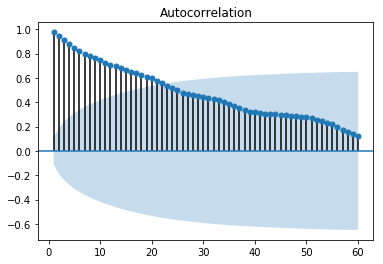

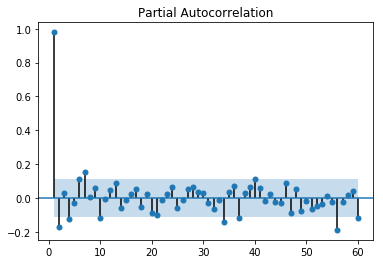

In [106]:
plot_acf(train['Price'], lags=60, zero=False);
plot_pacf(train['Price'], lags=60, zero=False);

+ 接下来我们将根据训练数据创建模型，得到模型的系数后，将其乘以测试数据将要执行的值: 

In [107]:
ar_train = train[['Price']]
ar_train.columns = ['Real']

#Creating the model:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ar_train['Real'], order=[2,0]).fit()
ar_train['Pred'] = model.predict(start=0, end=len(ar_train)-1)

# Checking the auto regressive model error
error_train['Auto Regr.'] = check_error(ar_train['Real'], ar_train['Pred'])
error_train

,Simple,Simple Mean,5D Moving Avg,Exp. Moving Avg,Auto Regr.
Training Base,,,,,
BIAS,-0.776975,-48.380689,-1.386457,-1.417022,-0.223745
MSE,710.170676,16627.945540,1060.410492,1107.936294,714.685244
RMSE,26.649028,128.949391,32.563945,33.285677,26.733598
MAE,16.880605,109.541113,22.017363,22.252195,17.082571
MAPE,3.106204,22.462558,4.101531,4.121165,3.145052


AUTO REGRESSIVE MODEL IN THE TEST DATA


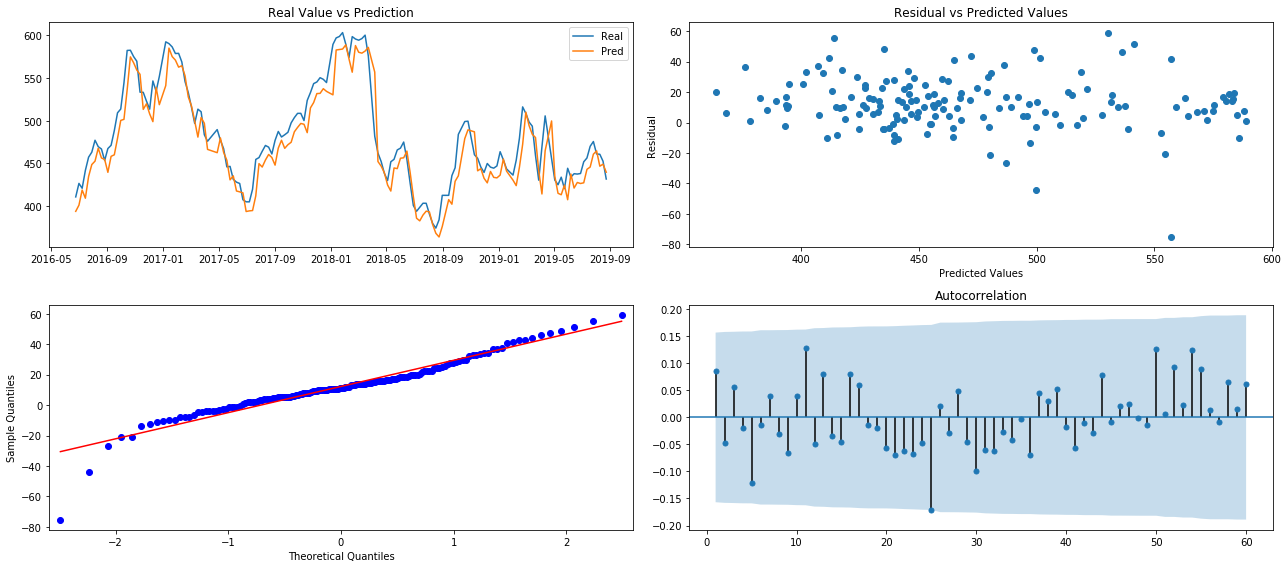

,Simple,Simple Mean,5D Moving Avg,Exp. Moving Avg,Auto Regr.
Training Base,,,,,
BIAS,-0.776975,-48.380689,-1.386457,-1.417022,12.263825
MSE,710.170676,16627.945540,1060.410492,1107.936294,451.674393
RMSE,26.649028,128.949391,32.563945,33.285677,21.252633
MAE,16.880605,109.541113,22.017363,22.252195,16.421986
MAPE,3.106204,22.462558,4.101531,4.121165,3.387982


In [108]:
ar_test = test[['Price']]
ar_test.columns = ['Real']

#validating the data using the coefficients of the trained model:
coef_l1, coef_l2 = model.arparams
hist = [ar_train.iloc[i,0] for i in range(len(ar_train))]
pred = []
for t in range(len(ar_test)):
    yhat = (hist[-1] * coef_l1) + (hist[-2] * coef_l2)
    obs = ar_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)
    
ar_test['Pred'] = pred

#plotting the test chart
print('AUTO REGRESSIVE MODEL IN THE TEST DATA')
plot_error(ar_test)

# Checking the auto regressive model error
error_train['Auto Regr.'] = check_error(ar_test['Real'], ar_test['Pred'])
error_train

+ 注意，在测试数据中，误差不会保持稳定，甚至会比简单模型更差，可以看到图中的预测值几乎总是低于当前值，偏差测量显示实际值比预测值高 50.19 BRL， 也许在训练模型中调整一些参数，这种差异会减小。m